# Group 16: SIT307 Machine Learning Group Project (Assignment 3)

<br>
Dataset Selected: <b>COVID-19 World Vaccination Progress</b>

Found at: https://www.kaggle.com/gpreda/covid-world-vaccination-progress

Collected by: <b>Gabriel Preda</b>

Updated: <b>Daily</b>

Date of download used: <b>17th May 2021</b>

<br><br>
<b>Supplementary data sets found at:</b>

https://www.kaggle.com/tanuprabhu/population-by-country-2020

https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

#### Import libraries used

In [1]:
# import libraries used
import numpy as np
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime
import datetime as dt
pd.set_option('float_format', '{:f}'.format)

import warnings
warnings.filterwarnings('ignore')

### Functions Used in this Notebook

In [2]:
""" 
    Funtion that calculates mean squared error after scaling
    Requires:
        predictions made by model
        Ytest correct outcomes
"""
def MSE(predictions, Ytest):
    # take predictions and Y test set as dataframe
    preds_mse = pd.DataFrame(predictions)
    Ytest_mse = pd.DataFrame(Ytest)
    
    # take the max of prediction and scale all predicitons
    pred_max = preds_mse.max()
    preds_mse = preds_mse / pred_max

    # take the max of Y test and scale all Y test values
    Ytest_max = Ytest_mse.max()
    Ytest_mse = Ytest_mse / Ytest_max 
    
    # return MSE of scaled data
    return round(list(np.mean((preds_mse - Ytest_mse) ** 2))[0],3)

In [3]:
""" 
    Funtion to convert date in string format to ordinal
    Requires:
        a date in string format (DD/MM/YYYY)
"""
def date_to_ordinal(date):
    return datetime.strptime(date, '%d/%m/%Y').date().toordinal()

In [4]:
""" 
    Funtion to convert date column in string/object format to ordinal
    Requires:
        a date column in a dataframe
"""
def date_to_ordinal_df(df):
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].map(dt.datetime.toordinal)
    return df

In [5]:
""" 
    Funtion to convert ordinal number to date format
    Requires:
        an ordinal number (int)
"""
def ordinal_to_datetime(ordinal):
    ordinal_to_datetime = int(ordinal)
    ordinal_to_datetime = dt.date.fromordinal(abs(ordinal_to_datetime))
    return ordinal_to_datetime

In [6]:
""" 
    Funtion to convert date column in ordianl format to date
    Requires:
        a date column in a dataframe in ordinal (ints)
"""
def ordinal_to_datetime_arr(arr):
    new_arr = []
    for num in arr:
        num = int(num)
        new_arr.append(dt.date.fromordinal(abs(num)))
    return new_arr

In [7]:
""" 
    Funtion that plots linear regression and real data
    Requires:
        X data set
        Y data set
        X test data set
        predictions made by model
"""
def plot_LR(X, Y, Xtest, predictions):
    # Plot outputs
    plt.scatter(X, Y,  color='red', s=5)
    plt.plot(Xtest, predictions, color='blue', linewidth=3)
    plt.xticks(rotation=90)

    # show plot
    plt.show()

## Kelly's Section

### Prediction of What Date a Country Will Have Vaccinated a Provided Percentage of Their Population

Implementing univariant linear regression on people fully vaccinated per hundred by date for different countries. Providing a country and a target percentage, this section will predict what date the country provided will achieve the target percentage of population vaccinated.
<br>

In [8]:
# read in cleaned dataset
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [9]:
# take only the columns of interest
vaccination_1 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]

# show this shape
print(vaccination_1.shape)

(17607, 3)


In [10]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_1 = vaccination_1[vaccination_1['people_fully_vaccinated_per_hundred'].notna()]

# change date object to ordinal to be used in linear regression
date_to_ordinal_df(vaccination_1)

# print the new shape
print(vaccination_1.shape)

(7185, 3)


In [11]:
""" 
    Function to find a date of the given target percentage for the population fully vaccinated
    Requires:
        -the pandas dataframe being worked on
        -a valid country in string format, and
        -target percentage
"""
def date_to_be_target_percentage(df, country, percentage, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_fully_vaccinated_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        determin_date = (LR.intercept_ - percentage )/LR.coef_
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the date of the target percentage for the fully vaccinated of country population
        # the mean squared error, the Y intercept and the slope
        return determin_date, mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
#         print(country, "has no data for people_fully_vaccinated_per_hundred.")
        return False, False, False, False

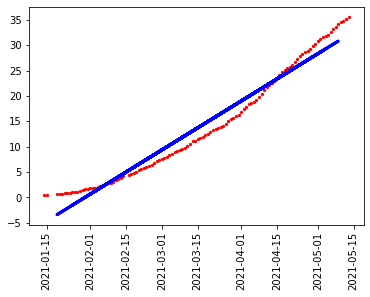

The MSE for this model is 0.005
We predict that 85% of the United States population will be fully immunized by 2021-10-30.


In [12]:
# determine a country to investigate
country_for_perc = 'United States'

# determine a date
target_percentage_of_immunization = 85

# call function with the dataset, country and target_percentage_of_immunization
# store returned values to be printed
date, mse, y_intercept, slope = date_to_be_target_percentage(vaccination_1, country_for_perc, target_percentage_of_immunization, True)

print("The MSE for this model is {0}".format(mse))

print("We predict that {0}% of the {1} population will be fully immunized by {2}.".format(target_percentage_of_immunization, country_for_perc, ordinal_to_datetime(date)))

In [13]:
# Create a new dataframe
pred_70_date = pd.DataFrame(columns=['country','ord_date','mse','y_intercept','slope'])

# Copy unique country value from previous dataframe
pred_70_date['country'] = vaccination_1['country'].unique().copy()

In [14]:
# Calulate each country's predicted herd immunity date
target_percentage_of_immunization = 70

pred_70_date['ord_date']  = pred_70_date['country'].map(lambda x : date_to_be_target_percentage(vaccination_1,x,target_percentage_of_immunization, 0)[0])
pred_70_date['mse']  = pred_70_date['country'].map(lambda x : date_to_be_target_percentage(vaccination_1,x,target_percentage_of_immunization, 0)[1])
pred_70_date['y_intercept']  = pred_70_date['country'].map(lambda x : date_to_be_target_percentage(vaccination_1,x,target_percentage_of_immunization, 0)[2])
pred_70_date['slope']  = pred_70_date['country'].map(lambda x : date_to_be_target_percentage(vaccination_1,x,target_percentage_of_immunization, 0)[3])
pred_70_date.head()

,country,ord_date,mse,y_intercept,slope
0,Afghanistan,False,False,False,False
1,Albania,[-738810.4695605042],0.774000,-52814.655974,[0.0715808155852732]
2,Andorra,[-738685.9787968441],0.014000,-61075.108776,[0.08277551020408166]
3,Angola,False,False,False,False
4,Anguilla,False,False,False,False


In [15]:
# Update the ordinal date to absolute value
# Replace 0, inf, -inf values to np.nan values
pred_70_date['ord_date']= pred_70_date['ord_date'].abs()
pred_70_date.replace(0, np.nan,inplace=True)
pred_70_date.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
# Drop nan values
pred_70_date.dropna(inplace=True)

In [17]:
# Update the ordinal date to datetime format and seperate into the predicted year and month [1]
pred_70_date['pred_date'] = pred_70_date['ord_date'].apply(lambda x : ordinal_to_datetime(x))
pred_70_date['pred_date'] = pd.to_datetime(pred_70_date['pred_date'], format="%Y/%m/%d", errors='coerce')
pred_70_date['pred_year'] = pd.to_datetime(pred_70_date['pred_date']).dt.strftime('%Y')
pred_70_date['pred_month']= pd.to_datetime(pred_70_date['pred_date']).dt.strftime('%m')
pred_70_date.head()

,country,ord_date,mse,y_intercept,slope,pred_date,pred_year,pred_month
1,Albania,[738810.4695605042],0.774000,-52814.655974,[0.0715808155852732],2023-10-17,2023,10
2,Andorra,[738685.9787968441],0.014000,-61075.108776,[0.08277551020408166],2023-06-14,2023,06
5,Argentina,[740827.6611530225],0.024000,-17151.047490,[0.023245686403527855],2029-04-25,2029,04
6,Aruba,[738023.3625005757],0.002000,-323978.564062,[0.4390762955854126],2021-08-21,2021,08
7,Austria,[738559.5436337377],0.007000,-69625.340128,[0.09436658253084461],2023-02-08,2023,02


In [18]:
# Find the number of countries reaching herd immunity per month/year using a pivot table and replace the nan value to zero.
pred_70_pivot = pd.pivot_table(
    pred_70_date, values="country", index="pred_year", columns="pred_month", aggfunc="count", fill_value = 0).astype(int)
pred_70_pivot

pred_month,01,02,03,04,05,06,07,08,09,10,11,12
pred_year,,,,,,,,,,,,
2021,0,0,1,0,2,3,5,3,2,1,2,2
2022,4,3,1,0,0,2,1,4,0,0,5,2
2023,4,5,4,4,0,4,3,3,1,3,0,1
2024,1,0,0,1,0,0,0,0,1,0,0,1
2025,0,0,0,0,0,0,1,0,0,1,0,1
2026,1,0,0,1,0,0,1,0,1,0,1,1
2027,0,0,0,0,0,1,0,1,0,0,1,0
2028,0,1,0,1,0,0,0,0,0,0,0,0
2029,1,0,0,1,0,0,1,0,0,0,0,0


In [19]:
# Graph to see how countries will reach the herd immunity by month and year [2]

ax = pred_70_pivot.plot(kind="bar")

# Get a Matplotlib figure from the axes object for formatting purposes

fig = ax.get_figure()
# Change the plot dimensions (width, height)

fig.set_size_inches(15, 6)
# Change the axes labels

ax.set_xlabel("Years")
ax.set_ylabel("Number of countries")

SyntaxError: unmatched ']' (<ipython-input-19-056b9ecabac1>, line 14)

In [ ]:
pred_70_pivot['sum'] = pred_70_pivot.sum(axis=1)
pred_70_pivot['cumsum'] = pred_70_pivot['sum'].cumsum()
pred_70_pivot['pcumsum'] = 100 * pred_70_pivot['cumsum']/pred_70_pivot['sum'].sum()

In [ ]:
# set style to whitegrid
sns.axes_style("whitegrid")
# set graph size
sns.set(rc={'figure.figsize':(12,9)})


graph = sns.lineplot(x="pred_year", y="pcumsum", data=pred_70_pivot)

# label plot
plt.title("% of world countries by year \nthat reaches Covid Herd Immunity (70% of their population)\n", size=18)
plt.xlabel("\nYear")
plt.ylabel("% world coutries ")
plt.xticks(rotation = 90 )


# show plot
plt.show()

## Sean's Section

### Prediction of What Percentage of a Countries Population Will Be Vaccinated by a Given Date

Implementing univariant linear regression on people fully vaccinated per hundred by date for different countries. Providing a country and a date, this section will predict what percentage of the countries population will be fully vaccinated by the provided date. If the date provided gives a value of over 100% (the country has fully vaccinated their population before this date), a further machine learning model will be called to determine what date they are predicted to achieve 100% vaccination.
<br><br>
Some countries don't provide data in the people_fully_vaccinated_per_hundred column. When this is the case the function will return this fact. If this is the case, there is a second machine learning model further down which uses total_vaccinations_per_hundred to determine how many vaccinations have been administered scaled to the population (maximum of 200% for 2 doses for each person).

In [ ]:
# read in cleaned dataset to new data frame
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [ ]:
# take only the columns of interest
vaccination_2 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]

# show this shape
print(vaccination_2.shape)

In [ ]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_2 = vaccination_2[vaccination_2['people_fully_vaccinated_per_hundred'].notna()]

# print the new shape
print(vaccination_2.shape)

In [ ]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_2['date'] = pd.to_datetime(vaccination_2['date'])
vaccination_2['date'] = vaccination_2['date'].map(dt.datetime.toordinal)

In [ ]:
""" 
    Funtion to determine the percentage of the given countries population fully vaccinated at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def perc_fully_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_fully_vaccinated_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_fully_vaccinated_per_hundred".format(country))
        return False, False, False, False

In [ ]:
# determine a country to investigate
country_perc_full = 'United States'
# determine a date
date_perc_full = '23/10/2021'

# call function with the dataset, country and date
# store returned values to be printed
perc_at_date, mse_perc, y_intercept, slope = perc_fully_vaccinated_at_date(vaccination_2, country_perc_full, date_perc_full, True)

if perc_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse_perc))
    print()
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if perc_at_date > 100:
        date_100, mse_date, y_intercept, slope = date_to_be_target_percentage(vaccination_2, country_perc_full, 100, False)
        print("It is predicted the {0} will have fully vaccinate their population by {1}.".format(country_perc_full, ordinal_to_datetime(date_100)))
    else:
        # print data
        print("{0} will have fully vaccined {1}% of their population by the date {2} based on current tracking.".format(country_perc_full, str(round(perc_at_date[0], 2)), date_perc_full))

### For Countries Without people_fully_vaccinated_per_hundred Data
<br>
Calculating total number of vaccinations administered at a given date.
<br><br>
This is for countries that don't have data in the dataset for people_fully_vaccinated_per_hundred, so we will use the total number of vaccines administered to get a guide as to how many people may have been vaccinated (2 doses per each member of population so up to 200%)

In [ ]:
# read in cleaned dataset to new data frame
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [ ]:
# take only the columns of interest
vaccination_3 = vaccination[['country', 'date', 'total_vaccinations_per_hundred']]
# show this shape
print(vaccination_3.shape)

In [ ]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_3 = vaccination_3[vaccination_3['total_vaccinations_per_hundred'].notna()]
# print the new shape
print(vaccination_3.shape)

In [ ]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_3['date'] = pd.to_datetime(vaccination_3['date'])
vaccination_3['date'] = vaccination_3['date'].map(dt.datetime.toordinal)

In [ ]:
""" 
    Funtion to determine the total vaccinates provided by the given country at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def perc_people_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['total_vaccinations_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print(country, "has no data for total_vaccinations_per_hundred.")
        return False, False, False, False

In [ ]:
# determine a country to investigate
country_perc_ppl = 'Australia'
# determine a date
date_perc_ppl = '22/12/2021'


# call function with the dataset, country and date
# store returned values to be printed
total_at_date, mse_tot_ppl, y_intercept, slope = perc_people_vaccinated_at_date(vaccination_3, country_perc_ppl, date_perc_ppl, True)
    
if total_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse_tot_ppl))
    print()
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if total_at_date > 200:
        print("{0} is predicted to have administered over 200% of vaccinations to their population by {1}".format(country_perc_ppl, date_perc_ppl))
    else:
        # check if country is full vaccinated and tell user that, or print where the country will be at
        print("{0} will have administered {1}% of vaccines required to their population by the date {2} based on current tracking (200% required for 2 doses for each person).".format(country_perc_ppl, str(round(total_at_date[0], 2)), date_perc_ppl))

<br>

## Patrick's Section

### Prediction of How Many People a Country Will Have Vaccinated by a Provided Date

Implementing univariant linear regression on people_vaccinated by date for different countries. Providing a country and a date, this section will predict how many people the country provided will have vaccinated by the given date.
<br>

In [ ]:
# read in cleaned dataset to new data frame and country populations
vaccination = pd.read_csv('data/cleaned_vaccination.csv')
country_pop = pd.read_csv('data/population_by_country_2020.csv')

In [ ]:
# take only the columns of interest
vaccination_4 = vaccination[['country', 'date', 'people_vaccinated']]
country_pop = country_pop[['Country (or dependency)','Population (2020)']]

# show this shape
print(vaccination_4.shape)
print(country_pop.shape)

In [ ]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_4 = vaccination_4[vaccination_4['people_vaccinated'].notna()]

# print the new shape
print(vaccination_4.shape)

In [ ]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_4['date'] = pd.to_datetime(vaccination_4['date'])
vaccination_4['date'] = vaccination_4['date'].map(dt.datetime.toordinal)

In [ ]:
""" 
    Funtion to determine the number of the given countries population vaccinated at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def numbers_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_vaccinated'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the number of people vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_vaccinated".format(country))
        return False, False, False, False

In [ ]:
# determine a country to investigate
country_num = 'United States'
# determine a date
date_num = '23/09/2021'

# call function with the dataset, country and date
# store returned values to be printed
pop_at_date, mse_num, y_intercept, slope = numbers_vaccinated_at_date(vaccination_4, country_num, date_num, True)

if pop_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse_num))
    print()
    
    population = country_pop.loc[country_pop['Country (or dependency)'] == country_num].iat[0,1]
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if pop_at_date >= population:
        print("{0} with a population of {1} will be full vaccinated at this date:{2}".format(country_num, round(population), date_num))
        #date_target, mse_target, y_intercept, slope = date_to_be_target_percentage(vaccination_4, country_num, 100, False)
        #print("It is predicted the {0} will fully vaccinate their population on {1}.".format(country, ordinal_to_datetime(date_target)))
    else:
        # print data
        print("{0} will have {1} people fully vaccined by the date {2} based on current tracking.".format(country_num, str(round(pop_at_date[0])), date_num))

<br>

## Muz's Section

### Prediction of What Percentage of the Worlds Population Will Have Been Fully Vaccinated by a Provided Date

Implementing univariant linear regression on people_fully_vaccinated by date worldwide. Providing a date, this section will predict what percentage and how many of the worlds population will have been fully vaccinated by this date.
<br>

In [ ]:
# read in cleaned dataset to new data frame
vaccination_5 = pd.read_csv('data/cleaned_vaccination.csv')
worldwide_pop = pd.read_csv('data/population_by_country_2020.csv')

In [ ]:
# take only the columns of interest
vaccination_5 = vaccination[['date', 'people_fully_vaccinated']]
worldwide_pop = worldwide_pop[['Population (2020)']]

# show their shape
print(vaccination_5.shape)
print(worldwide_pop.shape)

In [ ]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_5 = vaccination_5[vaccination_5['people_fully_vaccinated'].notna()]
worldwide_pop = worldwide_pop[worldwide_pop['Population (2020)'].notna()]

# print the new shape
print(vaccination_5.shape)
print(worldwide_pop.shape)

In [ ]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_5['date'] = pd.to_datetime(vaccination_5['date'])
vaccination_5['date'] = vaccination_5['date'].map(dt.datetime.toordinal)

In [ ]:
# take the total world wide number of people vaccinated on each date
world_total_vac_by_date = vaccination_5.groupby(['date']).people_fully_vaccinated.sum().reset_index()

In [ ]:
# determine the worlds population
world_pop = worldwide_pop['Population (2020)'].sum()

In [ ]:
# setup linear regression
LR_world = LinearRegression()

# get X and Y variables
X_world = np.array(world_total_vac_by_date['date']).reshape((-1, 1))
Y_world = np.array(world_total_vac_by_date['people_fully_vaccinated'])
    
# Split the training and test data using 30% for testing
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_world, Y_world, test_size=0.3, random_state=19)
    
# train the model
LR_world.fit(Xtrain, Ytrain)

# test on test set
predictions_world = LR_world.predict(Xtest)

# calculate the mean square error
mse_world = MSE(predictions_world, Ytest)

# show the MSE to determine how accurate the model is
print("The mean squared error of this model is {0}.".format(mse_world))
print()

# Plot LR
plot_LR(ordinal_to_datetime_arr(X_world), Y_world, ordinal_to_datetime_arr(Xtest), predictions_world)

In [ ]:
# date we want to determine how much of the worlds population is vaccinated on
date_world_str = "05/05/2022"

# change date to ordinal data.
date_world = date_to_ordinal(date_world_str)

# determine the number of people fully vaccinated by this date using linear regression model
world_pop_vac_by = LR_world.intercept_ + LR_world.coef_ * date_world

# determine this as a percentage of the world
percentage_of_people_fully_vaccinated = ((world_pop_vac_by/world_pop)*100)

# print this data
print ("The total percentage of the worlds population fully vaccinated by {0} is predicted to be {1}%, which is {2} people ".format(date_world_str, round(percentage_of_people_fully_vaccinated[0], 2), round(world_pop_vac_by[0])))

### Asher's Section

Section for Asher to implement, test and apply machine learning.

In [ ]:
vaccination_6 = pd.read_csv('data/cleaned_vaccination.csv')

### Tung's Section

### Prediction of What Date will the population be wholely vaccinated provided the current GDP, Population and vaccination percentage

Implementing multiple linear regression on date by gdp value, population and vaccination percentage (people fully vaccinated per hundred). The purpose is for the machine using the given dataset to predict at what time will a given populace will be fully vaccinated with current gdp, population and current vacination percentage of that populace. 


In [ ]:
"""
    Function to predict the number of people in a given country being vaccinated for a given time, vaccination percentage, gdp
    (multivariant regression using population, people fully vaccinated per hundred and gdp vs date)
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
        a gdp value in decimal format
    """
def vaccinated_people_by_pop_gdp(df, pop, percentage, gdp):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        # get X and Y variables
        X = df[['Population (2020)', 'people_fully_vaccinated_per_hundred', '2019']].values
        Y = df['date'].values

        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)

        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x = df['Population (2020)']
        y = df['date']
        z = df['people_fully_vaccinated_per_hundred']
        c = df['2019']

        print("Coefficients: ", LR.coef_)
        print("Intercept: ",LR.intercept_)
        print("MSE: {:.2f}".format(metrics.mean_squared_error(predictions, Ytest)))
        print("RMSE: {:.2f}".format(np.sqrt(metrics.mean_squared_error(predictions, Ytest))))
        
        img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
        fig.colorbar(img)
        plt.show()
    
        # return the number of people vaccinated at the given date
        return LR.predict([[pop, percentage, gdp]])

    except:
        # if error has occured let user know
        print("An error has occured")
        return False

In [ ]:
vaccination = pd.read_csv('data/cleaned_vaccination.csv')
country_pop = pd.read_csv('data/population_by_country_2020.csv')
country_gdp = pd.read_csv('data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2163564.csv')

# take only the columns of interest
vaccination_7 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]
country_pop = country_pop[['Country (or dependency)','Population (2020)']]
country_gdp = country_gdp[['Country Name','2019']]

# merge tables for easier calculation
vac_df = pd.merge(left = vaccination_7, right = country_pop, left_on = 'country', right_on='Country (or dependency)')
vac_df = pd.merge(left = vac_df, right = country_gdp, left_on = 'country', right_on = 'Country Name')

#clear extra columns and na values for people_fully_vaccinated_per_hundred
vac_df = vac_df.drop(['Country (or dependency)', 'Country Name'], axis=1)
vac_df = vac_df[vac_df['people_fully_vaccinated_per_hundred'].notna()]

vac_df = vac_df.dropna()

# change date object to date time and then ordinal to be used in linear regression
vac_df['date'] = pd.to_datetime(vac_df['date'])
vac_df['date'] = vac_df['date'].map(dt.datetime.toordinal)

In [ ]:
# take just numerical columns and determine Z-score in new data frame called z-scores
z_score_cols = vac_df[['people_fully_vaccinated_per_hundred', 'Population (2020)','2019']].copy()

z_scores = pd.DataFrame(stats.zscore(z_score_cols, nan_policy='omit'))

print(z_scores[z_scores > np.abs(3.0)].count())

vac_df = vac_df[(np.abs(stats.zscore(vac_df.select_dtypes(exclude='object'))) < 3).all(axis=1)]

In [ ]:
# determine a popualtion
pop_multi = 330000000
# determine the desired percentage
percent_multi = 70
# determine the  gdp
gdp_multi = 1400000000000

date_multi = vaccinated_people_by_pop_gdp(vac_df, pop_multi, percent_multi, gdp_multi)

date_multi = ordinal_to_datetime(int(date_multi))
print("By {0}, the whole population that has {1:.2f} million people, with GDP of {2:.2f} billion and current vaccination progress of {3}% will be fully vaccinated".format(date_multi, pop_multi/1000000, gdp_multi/1000000000, percent_multi))

# References

1. stackoverflow, Extracting just Month and Year separately from Pandas Datetime column(https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column)
2. stackoverflow, Grouped bar plot (https://stackoverflow.com/questions/47796264/function-to-create-grouped-bar-plot/47797080#47797080)

